In [64]:
import sys
sys.path.append('../src/')
import g_selfatt.groups as groups
import torch
import models
from g_selfatt.utils import num_params
import torch
import torchvision
from datasets import MNIST_rot
import matplotlib.pyplot as plt
import numpy as np
import models
import torch
import g_selfatt.groups as groups
import models
from torch.cuda.amp import GradScaler, autocast
import torchvision.transforms.functional as TF

In [65]:
def get_transforms(image, n_rotations=4, flips=True):
    transforms = [image]

    # Rotations
    for i in range(1, n_rotations):
        angle = i * (360 / n_rotations)
        rotated_image = TF.rotate(image, angle, interpolation=TF.InterpolationMode.BILINEAR)
        transforms.append(rotated_image)

    # Flips
    if flips:
        flips = []
        for transform in transforms:
            flipped_image_lr = TF.hflip(transform)
            flips.append(flipped_image_lr)

        transforms.extend(flips)
        
    res = torch.cat(transforms)
    return res

In [66]:
model = models.GroupTransformer(
    group=groups.SE2(num_elements=8),  # note 8 rotations
    in_channels=1,
    num_channels=20,
    block_sizes=[2],
    expansion_per_block=1,
    crop_per_layer=[2, 0],
    image_size=28,
    num_classes=2,
    dropout_rate_after_maxpooling=0.0,
    maxpool_after_last_block=False,
    normalize_between_layers=False,
    patch_size=5,
    num_heads=9,
    norm_type="LayerNorm",
    activation_function="Swish",
    attention_dropout_rate=0.1,
    value_dropout_rate=0.1,
    whitening_scale=1.41421356,
)

In [67]:
transform_test = torchvision.transforms.ToTensor()
test_set = MNIST_rot(root="../data", stage="test", download=True, transform=transform_test, data_fraction=1, only_3_and_8=True)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

In [68]:
data = iter(test_loader)
image, target = next(data)

In [69]:
model.eval()
transforms = get_transforms(image, n_rotations=8, flips=False)
logits = model(transforms)

In [70]:
logits

tensor([[  63.0084, -470.4396],
        [  86.0919, -462.4150],
        [  63.0084, -470.4396],
        [  86.0919, -462.4149],
        [  63.0084, -470.4395],
        [  86.0919, -462.4149],
        [  63.0084, -470.4395],
        [  86.0919, -462.4149]], grad_fn=<ViewBackward0>)

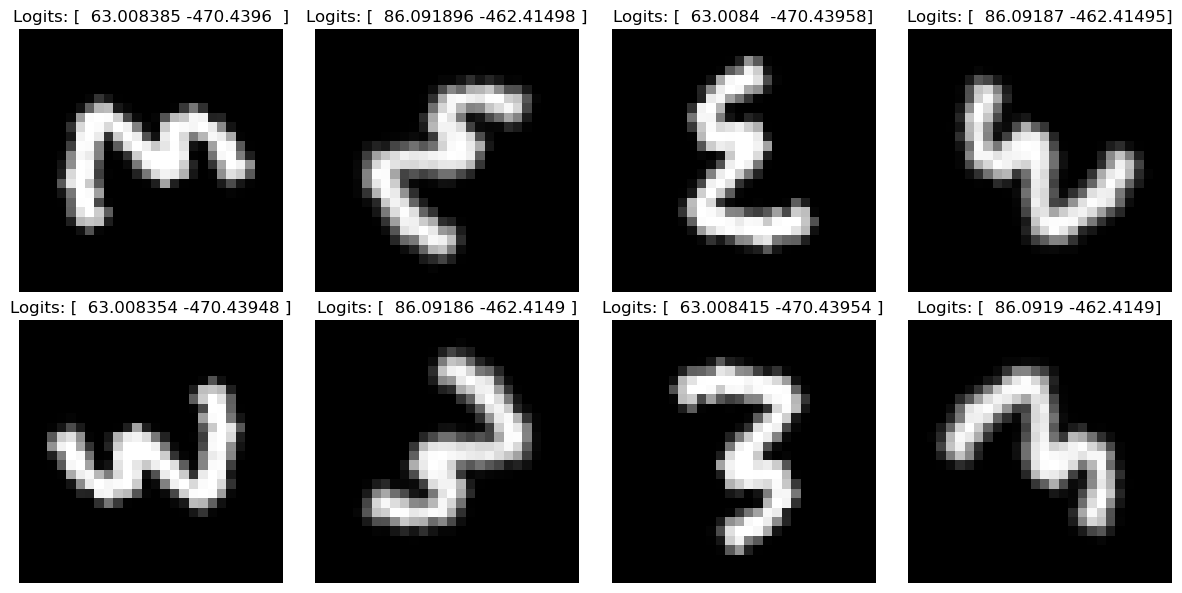

In [84]:
import matplotlib.pyplot as plt
logits = logits
transforms = get_transforms(image, n_rotations=8, flips=False)
transforms = transforms
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
axes = axes.flatten()
for i in range(8):
    ax = axes[i]
    ax.imshow(transforms[i, 0], cmap='gray')
    ax.set_title(f"Logits: {logits[i].detach().cpu().numpy()}")
    ax.axis('off')
plt.tight_layout()
plt.show()